In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

In [2]:
!python3 --version

Python 3.9.16


In [3]:
# !pip3 install -q odc.stac
# !pip3 install -q geopandas
# !pip3 install -q planetary_computer
# !pip3 install -q rioxarray
# !pip3 install -q loguru

In [4]:
# %load_ext lab_black
%load_ext autoreload
%autoreload 2

In [55]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc
import os
from datetime import date, timedelta

import multiprocessing
from multiprocessing import Pool

%matplotlib inline

In [6]:
import geopy.distance as distance

# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]



In [7]:
DATA_DIR = ''#Path.cwd().parent.resolve() / "data/final/public"
# DATA_DIR = '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/'#Path.cwd().parent.resolve() / "data/final/public"
# assert DATA_DIR.exists()

In [8]:
metadata = pd.read_csv(DATA_DIR + "metadata.csv")
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [9]:
len(metadata.uid.unique())

23570

In [10]:
len(metadata.loc[:,['latitude','longitude' 	]].drop_duplicates())

12681

In [11]:
duplicated_rows=np.where(metadata.loc[:,['latitude','longitude' 	]].duplicated()==True)[0]
duplicated_rows

array([   79,   106,   107, ..., 23565, 23566, 23569])

In [12]:
metadata.iloc[duplicated_rows[0],:]

uid                acdj
latitude        37.3906
longitude      -120.958
date         2015-04-14
split             train
Name: 79, dtype: object

In [13]:
metadata.loc[metadata['latitude']==metadata.latitude.iloc[duplicated_rows[0]],:].head()

,uid,latitude,longitude,date,split
22,aaqc,37.3906,-120.958,2013-07-09,train
79,acdj,37.3906,-120.958,2015-04-14,train
1701,bxeq,37.3906,-120.958,2019-09-10,train
2302,conk,37.3906,-120.958,2019-12-04,train
2409,crja,37.3906,-120.958,2021-07-13,train


In [14]:
metadata.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [15]:
import geopandas as gpd
from shapely.geometry import Point

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

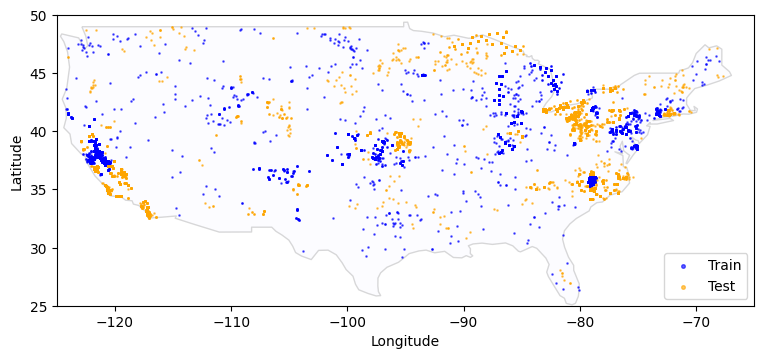

In [16]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)
plt.show()

In [17]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


In [18]:
# # what years are in the data?
# pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
# plt.ylabel("Number of samples")
# plt.xlabel("Year")
# plt.title("Distribution of years in the data")
# plt.show()

In [19]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

In [20]:
# # where is data from for each season?
# fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# for season, ax in zip(metadata.season.unique(), axes.flatten()):
#     base = world[world.name == "United States of America"].plot(
#         edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
#     )

#     sub = metadata[metadata.season == season]
#     geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
#     gdf = gpd.GeoDataFrame(sub, geometry=geometry)
#     gdf.plot(ax=base, marker=".", markersize=2.5)
#     ax.set_xlim([-125, -66])
#     ax.set_ylim([25, 50])
#     ax.set_title(f"{season.capitalize()} data points")
#     ax.axis("off")

In [21]:
train_labels = pd.read_csv(DATA_DIR + "train_labels.csv")
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [22]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

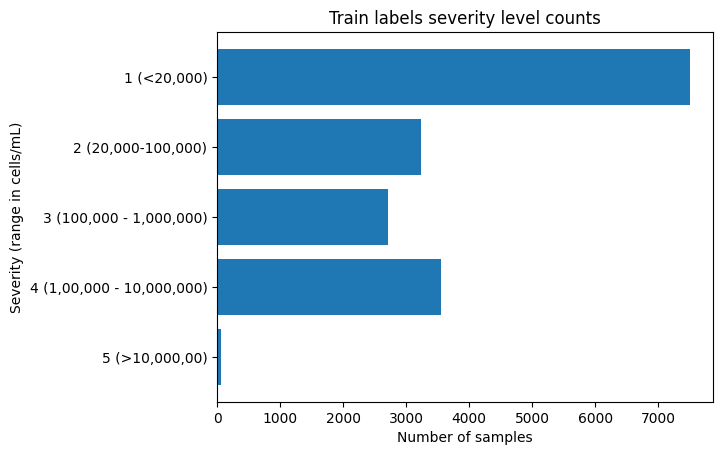

In [23]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [24]:
# train_labels.density.describe()

In [25]:
# (train_labels.density == 0).sum()

In [26]:
submission_format = pd.read_csv(DATA_DIR + "submission_format.csv", index_col=0)
submission_format.head()

,region,severity
uid,,
aabn,west,1
aair,west,1
aajw,northeast,1
aalr,midwest,1
aalw,west,1


In [27]:
submission_format.shape

(6510, 2)

In [28]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [49]:
metadata['latlong']=metadata['latitude'].round(2).astype(str)+'_'+metadata['longitude'].round(2).astype(str)
unique_points=np.unique(metadata.latlong)
metadata.head()

,uid,latitude,longitude,date,split,latlong
0,aabm,39.080319,-86.430867,2018-05-14,train,39.08_-86.43
1,aabn,36.559700,-121.510000,2016-08-31,test,36.56_-121.51
2,aacd,35.875083,-78.878434,2020-11-19,train,35.88_-78.88
3,aaee,35.487000,-79.062133,2016-08-24,train,35.49_-79.06
4,aaff,38.049471,-99.827001,2019-07-23,train,38.05_-99.83


In [50]:
distance_search = distance.distance(meters=1000)

# calculate the lat/long bounds based on ground distance
# bearings are cardinal directions to move (south, west, north, and east)
distance_search.destination((39.080319,-86.430867), bearing=180)[0]

39.071311364712614

In [51]:
len(metadata),len(unique_points)

(23570, 2680)

In [52]:
# lat,long=unique_points[0].split('_')
# lat=float(lat)
# long=float(long)
# unique_points[0],lat,long

In [53]:
metadata=pd.read_csv('metadata.csv')
metadata['date']=pd.to_datetime(metadata['date'])
metadata.head()

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


In [54]:
# undates=metadata['date'].unique()
undates=np.unique(metadata['date'])
undates=pd.DatetimeIndex(undates)
len(undates),undates[0]

(1637, Timestamp('2013-01-04 00:00:00'))

In [56]:
import tempfile, requests

In [57]:
# str(date)+'_db'+str(days_before)

In [58]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [59]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                         garm
latitude                41.98006
longitude             -110.65734
date         2021-09-27 00:00:00
split                      train
Name: 5461, dtype: object

In [60]:
import geopy.distance as distance

In [61]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=5000)
bbox

[-110.71767063416925,
 41.93504434061374,
 -110.59700936583076,
 42.02507530515421]

In [62]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date)
date_range

'2021-09-12T/2021-09-27T'

In [63]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

7

In [64]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 7 returned to 7 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
6,2021-09-12,landsat-8,True,"[-111.34023745, 40.67702495, -108.51528663, 42..."
5,2021-09-14,Sentinel-2A,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
3,2021-09-19,Sentinel-2B,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
4,2021-09-19,landsat-8,True,"[-112.92522743, 40.67353498, -110.06644659, 42..."
2,2021-09-20,landsat-7,True,"[-111.60018779, 40.80284495, -108.59831681, 42..."
1,2021-09-24,Sentinel-2A,True,"[-111.000244, 41.4562419, -109.665115, 42.4526..."
0,2021-09-27,landsat-7,True,"[-113.18385774, 40.78803499, -110.15150674, 42..."


In [65]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
1,2021-09-24,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.4562419, -109.665115, 42.4526...",<Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...,True
3,2021-09-19,Sentinel-2B,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2B_MSIL2A_20210919T180919_R084_T12TW...,True
5,2021-09-14,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2A_MSIL2A_20210914T180951_R084_T12TW...,True


In [66]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-24
platform                                                       Sentinel-2A
min_long                                                       -111.000244
max_long                                                       -109.665115
min_lat                                                          41.456242
max_lat                                                          42.452691
bbox                     [-111.000244, 41.4562419, -109.665115, 42.4526...
item_obj                 <Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...
contains_sample_point                                                 True
Name: 1, dtype: object

In [67]:
item = best_item.item_obj

In [68]:
item.datetime

datetime.datetime(2021, 9, 24, 18, 11, 1, 24000, tzinfo=tzutc())

In [69]:
item.datetime.strftime("%Y-%m-%d-%H")

'2021-09-24-18'

In [70]:
item.extra_fields

{'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json',
  'https://stac-extensions.github.io/sat/v1.0.0/schema.json',
  'https://stac-extensions.github.io/projection/v1.0.0/schema.json']}

In [71]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [72]:
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [73]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [74]:
# print(img.height)

Image(url=item.assets['visual'].href)
# Image(url=item.assets['rendered_preview'].href)
# PILImage.open(item.assets['rendered_preview'].href)

In [75]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    # image = rioxarray.open_rasterio(pc.sign(item.assets["B02"].href)).rio.clip_box(
    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

S2Bands= ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 
         'AOT', 'SCL']
S2resgroups=[['B02', 'B03', 'B04', 'B08'], #10m, 1,2,3,7
             ['B05', 'B06', 'B07', 'B11', 'B12', 'B8A'], #20m 4,5,6,9,10,11
             ['B01', 'B09'] ] #60m 0,8
def crop_sentinel_image3(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box


    imageL=[]
    for band in S2Bands:
        imageL.append( rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        ).to_numpy()   )

    image10=np.vstack([imageL[1],imageL[2],imageL[3],imageL[7], imageL[12]])#.astype('uint8')
    image20=np.vstack([imageL[4],imageL[5],imageL[6],imageL[9],imageL[10],imageL[11], imageL[13]])#.astype('uint8')
    image60=np.vstack([imageL[0],imageL[8]])#.astype('uint8')
    # return imageL  
    # return np.clip(np.vstack(imageL[1:4])[::-1]**0.75, 0,255)).astype('uint8')
    # return np.vstack(imageL[[ 1,2,3,7]]).astype('uint8'), np.vstack(imageL[[ 4,5,6,9,10,11]]).astype('uint8'), np.vstack(imageL[[ 0,8]]).astype('uint8')
    return image10, image20, image60


In [76]:
# it= rioxarray.open_rasterio(pc.sign(item.assets['AOT'].href)).rio.clip_box(
#             minx=minx,
#             miny=miny,
#             maxx=maxx,
#             maxy=maxy,
#             crs="EPSG:4326",
#         ).to_numpy()
# it.shape

In [77]:
# item.get_assets()

In [78]:
# item.assets[]

In [79]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
# zoomed_img_array = crop_sentinel_image(item, bbox)

# zoomed_img_array[0].shape
image10, image20, image60  = crop_sentinel_image3(item, bbox)

In [94]:
np.transpose(image10,(1,2,0)).max(),image10[:3,...].max()

(6092, 5448)

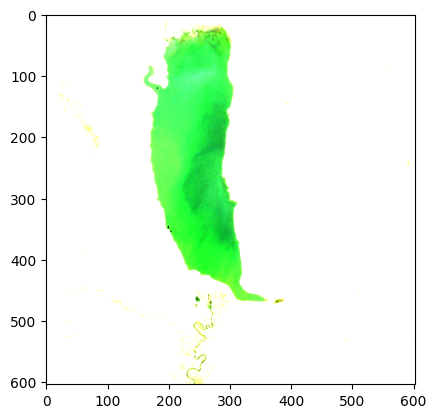

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


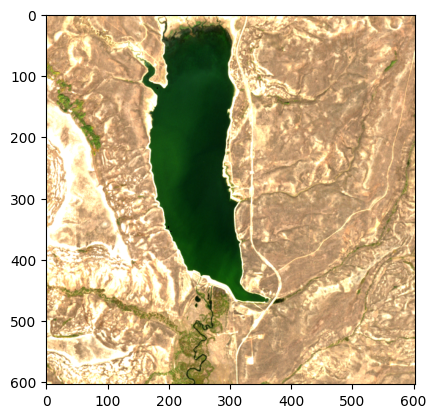

In [102]:
plt.imshow(np.transpose(np.clip(image10[[2,1,0],...], 0,255),(1,2,0)).astype('uint8'))
plt.show()
plt.imshow(4*np.transpose(image10[[2,1,0],...],(1,2,0))/image10[:3,...].max())
plt.show()

In [103]:
image10.shape, image20.shape

((5, 604, 603), (7, 302, 302))

In [104]:
np.unique(image20[-1,...])

array([0, 2, 4, 5, 6, 7, 8], dtype=uint16)

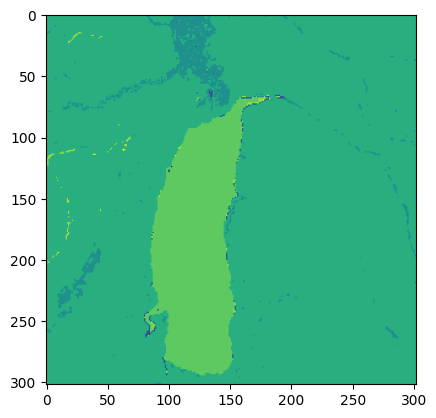

In [105]:
plt.imshow((np.clip(image20[-1,...][::-1,...], 0,255)).astype('uint8'))
plt.show()

In [106]:
# plt.imshow(np.transpose((np.clip(image10[:3,...][::-1,...], 0,255)).astype('uint8'), axes=[1, 2, 0]))
# plt.show()
# plt.imshow(np.transpose((np.clip(image10[[0,1,3],...][::-1,...], 0,255)).astype('uint8'), axes=[1, 2, 0]))
# plt.show()

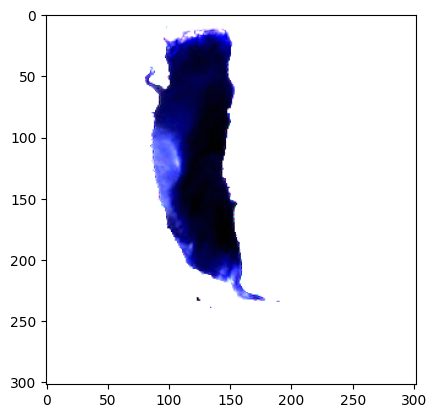

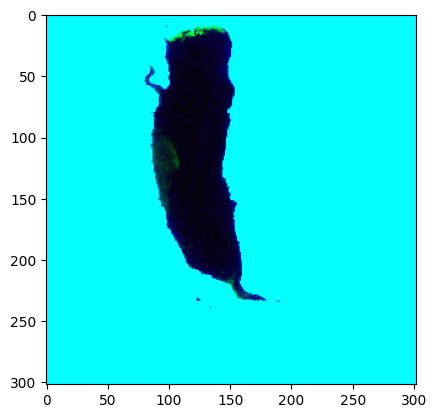

In [107]:
plt.imshow(np.transpose((np.clip(image20[:3,...][::-1,...], 0,255)).astype('uint8'), axes=[1, 2, 0]))
plt.show()
plt.imshow(np.transpose((np.clip(image20[-3:,...][::-1,...], 0,255)).astype('uint8'), axes=[1, 2, 0]))
plt.show()

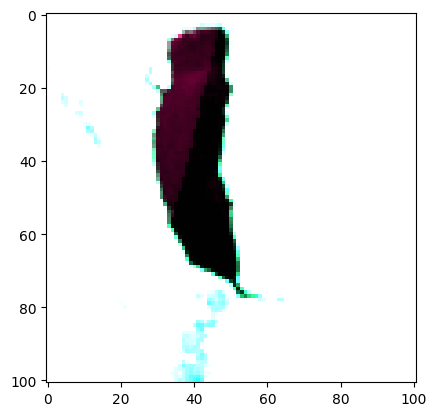

In [108]:
plt.imshow(np.transpose((np.clip(np.stack([image60[0,...],image60[1,...],(image60[0,...]+image60[1,...])/2]), 0,255)).astype('uint8'), axes=[1, 2, 0]))
plt.show()

In [109]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    # image = rioxarray.open_rasterio(pc.sign(item.assets["B02"].href)).rio.clip_box(
    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]    

array([[214, 224, 213, ..., 124, 109, 103],
       [215, 220, 201, ..., 114,  95,  94],
       [217, 222, 187, ..., 106,  95,  94],
       ...,
       [223, 185, 193, ..., 112, 118, 120],
       [181, 140, 190, ..., 110, 111, 117],
       [134, 125, 185, ..., 107, 107, 111]], dtype=uint8)

In [110]:
zoomed_img_array[0].shape

(604, 603)

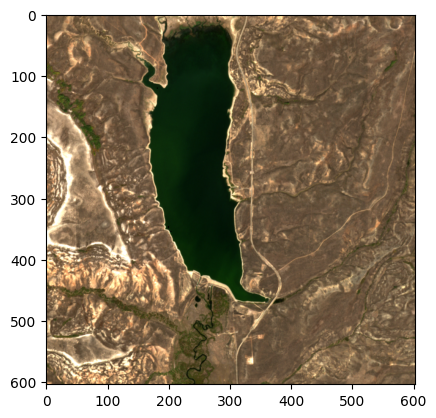

In [111]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))
plt.show()

In [112]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item

datetime                                                        2021-09-12
platform                                                         landsat-8
min_long                                                       -111.340237
max_long                                                       -108.515287
min_lat                                                          40.677025
max_lat                                                          42.817595
bbox                     [-111.34023745, 40.67702495, -108.51528663, 42...
item_obj                         <Item id=LC08_L2SP_037031_20210912_02_T1>
contains_sample_point                                                 True
Name: 6, dtype: object

In [113]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
#     image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [114]:
bbox
item

ID: S2A_MSIL2A_20210924T181101_R084_T12TWM_20210925T141709
"Bounding Box: [-111.000244, 41.4562419, -109.665115, 42.4526912]"
Datetime: 2021-09-24 18:11:01.024000+00:00
datetime: 2021-09-24T18:11:01.024000Z
platform: Sentinel-2A
proj:epsg: 32612
instruments: ['msi']
s2:mgrs_tile: 12TWM
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20210925T141710_A032685_T12TWM_N03.00
eo:cloud_cover: 0.171977


In [115]:
item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]

array([[12933, 13488, 11722, ..., 10544, 10770, 10988],
       [13164, 13673, 11810, ..., 10660, 11079, 10844],
       [13250, 13085, 11760, ..., 11094, 11137, 10551],
       ...,
       [13158, 12414, 11900, ..., 11263, 11087, 11157],
       [11882, 11630, 11493, ..., 11082, 10912, 10931],
       [14101, 13137, 12880, ..., 10945, 10871, 11113]], dtype=uint16)

In [116]:
landsat_image_array.min()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


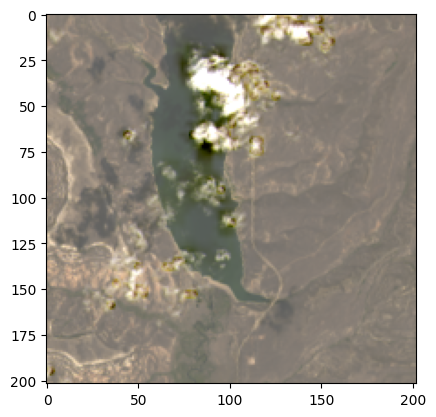

In [117]:
plt.imshow(0.5+np.transpose(((landsat_image_array-landsat_image_array.mean())/landsat_image_array.std())/((landsat_image_array-landsat_image_array.mean())/landsat_image_array.std()).max(), axes=[1, 2, 0]))
# plt.imshow(np.transpose(landsat_image_array/landsat_image_array.max(), axes=[1, 2, 0]))
plt.show()

In [122]:
# plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))
# plt.show()

In [119]:
# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
image_array[0]

<xarray.DataArray (y: 202, x: 202)>
array([[12933, 13488, 11722, ..., 10544, 10770, 10988],
       [13164, 13673, 11810, ..., 10660, 11079, 10844],
       [13250, 13085, 11760, ..., 11094, 11137, 10551],
       ...,
       [13158, 12414, 11900, ..., 11263, 11087, 11157],
       [11882, 11630, 11493, ..., 11082, 10912, 10931],
       [14101, 13137, 12880, ..., 10945, 10871, 11113]], dtype=uint16)
Coordinates:
  * y            (y) float64 4.651e+06 4.651e+06 ... 4.645e+06 4.645e+06
  * x            (x) float64 5.254e+05 5.254e+05 ... 5.314e+05 5.314e+05
    spatial_ref  int32 32612
    time         datetime64[ns] 2021-09-12T18:01:53.979983
    variable     <U3 'red'

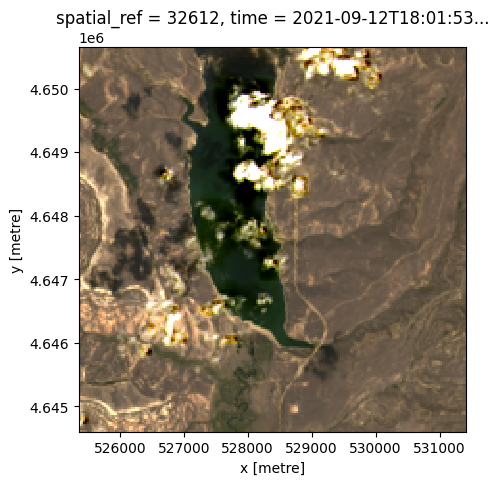

In [123]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

In [124]:
# define a small area to crop around
# crop to 400 meters squared around the sampling point
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=100
)
minx, miny, maxx, maxy

(-110.65854661288282,
 41.97915969028358,
 -110.6561333871172,
 41.980960309574755)

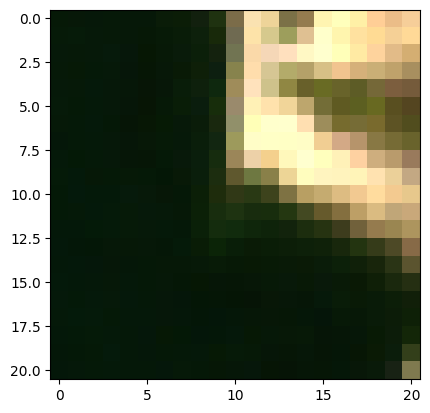

In [125]:
bbox = (minx, miny, maxx, maxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=bbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))
plt.show()

In [126]:
type(feature_image_array), feature_image_array.shape

(numpy.ndarray, (3, 21, 21))

# New section

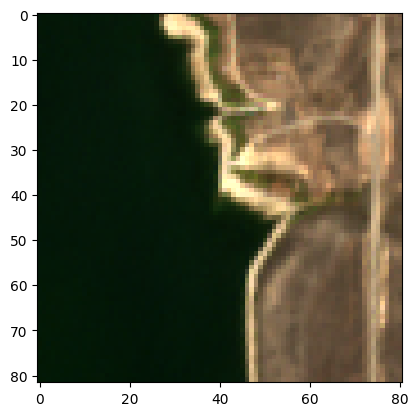

In [127]:
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=400
)
minx, miny, maxx, maxy
bbox = (minx, miny, maxx, maxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=bbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))
plt.show()

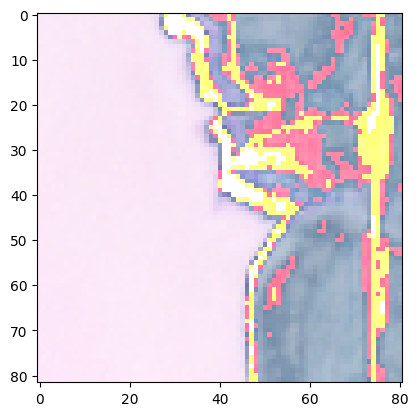

In [128]:
temp=feature_image_array.copy()
temp=255-temp
temp[feature_image_array>140]=255
plt.imshow(np.transpose(temp, axes=[1, 2, 0]))
plt.show()

In [129]:
# take the average over the second and third dimensions
image_color_averages = feature_image_array.mean(axis=(1, 2)).tolist()

# also take the median
image_color_medians = np.median(feature_image_array, axis=(1, 2)).tolist()

# concatenate the two lists
image_features = image_color_averages + image_color_medians
image_features


[69.9993977717555, 67.69722975007528, 43.55450165612767, 22.0, 38.0, 13.5]

In [130]:
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])

def select_best_item_from_platform(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
#                 "datetime": item.datetime.strftime("%Y-%m-%d"),
                "datetime": item.datetime.strftime("%Y-%m-%d-%H"),#cl90buf30days400mb5K
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )
#     print(item_details)
    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    best_itemS={'item_obj':np.nan,'datetime':np.nan}
    best_itemL={'item_obj':np.nan,'datetime':np.nan}    
    item_detailsS=item_details.copy()
    item_detailsL=item_details.copy()
    item_detailsS["sentinel"] = item_detailsS.platform.str.lower().str.contains(
        "sentinel"
    )
    item_detailsL["landsat"] = item_detailsL.platform.str.lower().str.contains(
        "landsat"
    )
    if item_detailsS["sentinel"].any():
        item_detailsS = item_detailsS[item_detailsS["sentinel"] == True]
        best_itemS = item_detailsS.sort_values(by="time_diff", ascending=True).iloc[0]
    if item_detailsL["landsat"].any():
        item_detailsL = item_detailsL[item_detailsL["landsat"] == True]        
        best_itemL = item_detailsL.sort_values(by="time_diff", ascending=True).iloc[0]

    # return the closest imagery by time
    
    

    return (best_itemS["item_obj"], best_itemS["datetime"],
            best_itemL["item_obj"], best_itemL["datetime"])

def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    # c0 = int(image_array.shape[1]/2)
    # c1 = int(image_array.shape[1]/2)
    # averages_zoomin = image_array[:,c0-1:c0+1,c1-1:c1+1].mean(axis=(1, 2)).tolist()
    # medians_zoomin = np.median(image_array[:,c0-1:c0+1,c1-1:c1+1], axis=(1, 2)).tolist()

    return averages + medians #+averages_zoomin + medians_zoomin

In [131]:
BENCHMARK_DATA_DIR = "benchmark/"#DATA_DIR.parents[1] / "benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR + "image_arrays/"
# IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)
import os
isExist = os.path.exists(IMAGE_ARRAY_DIR)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(IMAGE_ARRAY_DIR)

In [132]:
# take a random subset of the training data for the benchmark
# train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)
train_subset = metadata[metadata["split"] == "train"]

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

train    17060
test      6510
Name: split, dtype: int64

In [133]:
# !cp '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/image_arrays1Κ.zip' 'image_arrays1Κ.zip'
# !unzip -q image_arrays1Κ.zip -d /content/benchmark/image_arrays
# !cp '/gdrive/My Drive/Colab Notebooks/HarmfulAlgalBloomDetection/image_arrays.zip' 'image_arrays.zip'
# !unzip -q image_arrays.zip -d /content/benchmark/image_arrays

In [134]:
BENCHMARK_DATA_DIR = "benchmark/"#DATA_DIR.parents[1] / "benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIRs = BENCHMARK_DATA_DIR + "image_arraysS/"
# IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)
import os
isExist = os.path.exists(IMAGE_ARRAY_DIRs)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(IMAGE_ARRAY_DIRs)

IMAGE_ARRAY_DIRl = BENCHMARK_DATA_DIR + "image_arraysL/"
# IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)
import os
isExist = os.path.exists(IMAGE_ARRAY_DIRl)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(IMAGE_ARRAY_DIRl)   

In [135]:
import multiprocessing
from multiprocessing import Pool

num_cores = multiprocessing.cpu_count()
num_cores

24

In [136]:

# # for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
# # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
# def single_query(ind):
# #     selected_items = {}
#     row=metadata_subset.iloc[ind,:]
#     # pass
#     # check if we've already saved the selected image array
#     image_array_pthS = IMAGE_ARRAY_DIRs + f"{row.uid}"
#     image_array_pthL = IMAGE_ARRAY_DIRl + f"{row.uid}"

# #     try:
#     ## QUERY STAC API
#     # get query ranges for location and date
#     search_bbox = get_bounding_box(
#         row.latitude, row.longitude, meter_buffer=50000
#     )
#     date_range = get_date_range(row.date, time_buffer_days=15)

#     # search the planetary computer
#     search = catalog.search(
#         collections=["sentinel-2-l2a", "landsat-c2-l2"],
#         bbox=search_bbox,
#         datetime=date_range,
#     )
#     items = [item for item in search.get_all_items()]

#     ## 
#     if len(items) > 0:
#         best_itemS, item_dateS, best_itemL, item_dateL = select_best_item_from_platform(
#             items, row.date, row.latitude, row.longitude
#         )
# #         # add to dictionary tracking best items
# #         selected_items[row.uid] = {
# #             "item_objectS": best_itemS,
# #             "item_platformS": item_platformS,
# #             "item_dateS": item_dateS,
# #             "item_objectL": best_itemL,
# #             "item_platformL": item_platformL,
# #             "item_dateL": item_dateL,
# #         }
#         print(item_dateS,item_dateL)
#         ## CONVERT TO FEATURES
#         # get small bbox just for features
#         feature_bbox = get_bounding_box(
# #             row.latitude, row.longitude, meter_buffer=1000
#             row.latitude, row.longitude, meter_buffer=100
#         )

#         # crop the image
#         # if "sentinel" in item_platform.lower():
#         if str(best_itemS)!='nan':
#             image_arrayS = crop_sentinel_image3(best_itemS, feature_bbox)
#             np.savez_compressed(image_array_pthS, a=image_arrayS[0], b=image_arrayS[1], c=image_arrayS[2])
        
#         if str(best_itemL)!='nan':
#             image_arrayL = crop_landsat_image(best_itemL, feature_bbox)
#             np.savez_compressed(image_array_pthL, a=image_arrayL)

# #             del image_arrayS, image_arrayL, image_array_pthS, image_array_pthL
# #             del feature_bbox, selected_items, items, search, row, date_range, search_bbox
# #             del best_itemS, item_platformS, item_dateS, best_itemL, item_platformL, item_dateL
# #             gc.collect()

# #     except:
# #         pass


In [137]:
search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=bbox,
        query={"eo:cloud_cover": {"lt": 90}},  ################### NEW
        datetime=date_range,
    )
items = [item for item in search.get_all_items()]
len(items)

7

In [138]:

# for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
# for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
def single_query(ind):
#     selected_items = {}
    row=metadata_subset.iloc[ind,:]
    # pass
    # check if we've already saved the selected image array
    image_array_pthS = IMAGE_ARRAY_DIRs + f"{row.uid}"
    image_array_pthL = IMAGE_ARRAY_DIRl + f"{row.uid}"

#     try:
    ## QUERY STAC API
    # get query ranges for location and date
    search_bbox = get_bounding_box(
#         row.latitude, row.longitude, meter_buffer=50000
        row.latitude, row.longitude, meter_buffer=5000
#         row.latitude, row.longitude, meter_buffer=1000
    )
    date_range = get_date_range(row.date, time_buffer_days=10)

    # search the planetary computer
    search = catalog.search(
        collections=["sentinel-2-l2a", "landsat-c2-l2"],
        bbox=search_bbox,
        query={"eo:cloud_cover": {"lt": 30}},  ################### NEW
#         query={"eo:cloud_cover": {"lt": 90}},  ################### NEW
        datetime=date_range,
    )
    items = [item for item in search.get_all_items()]

    ## 
    if len(items) > 0:
        best_itemS, item_dateS, best_itemL, item_dateL = select_best_item_from_platform(
            items, row.date, row.latitude, row.longitude
        )
#         # add to dictionary tracking best items
#         selected_items[row.uid] = {
#             "item_objectS": best_itemS,
#             "item_platformS": item_platformS,
#             "item_dateS": item_dateS,
#             "item_objectL": best_itemL,
#             "item_platformL": item_platformL,
#             "item_dateL": item_dateL,
#         }
        print(item_dateS,item_dateL)
        ## CONVERT TO FEATURES
        # get small bbox just for features
        feature_bbox = get_bounding_box(
#             row.latitude, row.longitude, meter_buffer=1000
#             row.latitude, row.longitude, meter_buffer=100
            row.latitude, row.longitude, meter_buffer=400
        )

        # crop the image
        # if "sentinel" in item_platform.lower():
        if str(best_itemS)!='nan':
            image_arrayS = crop_sentinel_image3(best_itemS, feature_bbox)
            np.savez_compressed(image_array_pthS, a=image_arrayS[0], b=image_arrayS[1], 
                                c=image_arrayS[2], d=np.array([item_dateS]))
        
        if str(best_itemL)!='nan':
            image_arrayL = crop_landsat_image(best_itemL, feature_bbox)
            np.savez_compressed(image_array_pthL, a=image_arrayL, b=np.array([item_dateL]))

#             del image_arrayS, image_arrayL, image_array_pthS, image_array_pthL
#             del feature_bbox, selected_items, items, search, row, date_range, search_bbox
#             del best_itemS, item_platformS, item_dateS, best_itemL, item_platformL, item_dateL
#             gc.collect()

#     except:
#         pass


In [94]:
# with Pool(4) as pool:
#     pool.imap_unordered(single_query, np.arange(len(metadata_subset)))
# #     pool.map(single_query, np.arange(len(metadata_subset)))  
#     pool.close()

In [141]:
pool = Pool(processes=8)
for _ in tqdm(pool.imap_unordered(single_query, np.arange(len(metadata_subset))), total=len(metadata_subset)):
    pass


In [ ]:
# with multiprocessing.Pool(processes=8) as pool:
#     tqdm(pool.imap_unordered(single_query,  np.arange(len(metadata_subset)) ))
# #     a = tqdm(a)

In [139]:
gc.collect()

20960

In [140]:
# #Load 2 datasets
# IMAGE_ARRAY_DIRs = BENCHMARK_DATA_DIR + "image_arraysS100/"
# IMAGE_ARRAY_DIRl = BENCHMARK_DATA_DIR + "image_arraysL100/"
# # IMAGE_ARRAY_DIRs = BENCHMARK_DATA_DIR + "image_arraysS/"
# # IMAGE_ARRAY_DIRl = BENCHMARK_DATA_DIR + "image_arraysL/"
# features_dictS = {}
# features_dictL = {}
# for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
# # for row in tqdm(metadata_subset.iloc[:2,:].itertuples(), total=2):
#     # pass
#     # check if we've already saved the selected image array
#     image_array_pthS = IMAGE_ARRAY_DIRs + f"{row.uid}"
#     image_array_pthL = IMAGE_ARRAY_DIRl + f"{row.uid}"
#     # image_array_pthS = IMAGE_ARRAY_DIRs + f"{row.uid}.npy"
#     # image_array_pthL = IMAGE_ARRAY_DIRl + f"{row.uid}.npy"

#     # if image_array_pth.exists():
#     if os.path.exists(image_array_pthS+'.npz'):
# #         with open(image_array_pth, "rb") as f:
#         image_arrayS = np.load(image_array_pthS+'.npz')
#         image_arrayS10 = image_arrayS['a']
#         image_arrayS20 = image_arrayS['b']
#         image_arrayS60 = image_arrayS['c']

#         # convert image to 1-dimensional features
#         image_featuresS = image_to_features(image_arrayS10)+image_to_features(image_arrayS20)+image_to_features(image_arrayS60)
#         features_dictS[row.uid] = image_featuresS
        
#     if os.path.exists(image_array_pthL+'.npz'):
#         image_arrayL = np.load(image_array_pthL+'.npz')['a']
#         image_featuresL = image_to_features(image_arrayL)
#         features_dictL[row.uid] = image_featuresL
        